### Single cell analysis of human PDAC tissues

### NCBI GEO ID: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE155698


The scRNA-seq data was processed according to best practices of Seurat R pipeline [49]. The human scRNA data (GSE155698) comprising of 14698 cells (of 41178 cells) from PDAC tissues met the quality control thresholds and were subsequently normalized using standard (logarithmic) normalization with scale factor of 10000. The top 2000 highly variable features identified using Variance Stabilizing Transformation (VST) were used for principal component analysis (PCA). We used a conservative approach of using first 35 principal components for cell type clustering. The top 30 cluster markers for each cluster were used to annotate the clusters with their respective cell type using Enrichr database.The UMAP clustering (reclustering) of epithelial and myoepithelial clusters (C3,C4,C7,C11,C12, C21) were performed using the first 20 principal components generated with 1000 highly variable features (VST). Additionally, we identified all the MUC1-expressing cells and stratified them into mutually exclusive subgroups based on their expression (above minimum) of mucin (MUC5AC, MUC4, MUC16) and mesenchymal markers (SNAI2). The differential expression of these subgroups were further compared using the FindMarkers function from seurat R package. 

In [118]:
## R script to process the single cell human PDAC data (GSE155698). 
##required files (untitled markers file)

library(Seurat)
library(rhdf5)
library(monocle3)
library(SeuratWrappers)
library(pheatmap)
library(RColorBrewer)
library(dplyr)
library(Seurat)
library(reshape2)
library(ggpubr)
library(EnvStats)

In [119]:
## the processed matrices and annotations were retrieved from GSE155698 (NCBI GEO)

setwd("~/Documents/GSE155698/")

In [120]:
files = list.files(recursive = T)
print(files)

  [1] "256_cells_adm.csv"                                         
  [2] "acinar.csv"                                                
  [3] "APC_FAP.csv"                                               
  [4] "APCmin_adenoma_vs_control_colon.csv"                       
  [5] "APCmin_vs_nonapc_single_sample.csv"                        
  [6] "APCmin_vs_onesample_nonAPC_adenoma.csv"                    
  [7] "APCvsNonAPC_FAP.csv"                                       
  [8] "bars_seurat.csv"                                           
  [9] "c1_producing_cells.csv"                                    
 [10] "c5_ff.csv"                                                 
 [11] "c7.csv"                                                    
 [12] "cancer_LS_vs_normal.csv"                                   
 [13] "cflar_vs_myc.csv"                                          
 [14] "cluster12.csv"                                             
 [15] "colon.gz"                                              

In [121]:
 ## Samples being filtered out are 11A & 11B due to multiple sampling. we only used PDAC tissues for our analysis. 

files = files[grep("TISSUE", files)]
idx = grep("_11", files)
files = files[-idx]
print(files)

 [1] "PDAC_TISSUE_1/filtered_feature_bc_matrix/barcodes.tsv.gz" 
 [2] "PDAC_TISSUE_1/filtered_feature_bc_matrix/features.tsv.gz" 
 [3] "PDAC_TISSUE_1/filtered_feature_bc_matrix/matrix.mtx.gz"   
 [4] "PDAC_TISSUE_10/filtered_feature_bc_matrix/barcodes.tsv.gz"
 [5] "PDAC_TISSUE_10/filtered_feature_bc_matrix/features.tsv.gz"
 [6] "PDAC_TISSUE_10/filtered_feature_bc_matrix/matrix.mtx.gz"  
 [7] "PDAC_TISSUE_12/filtered_feature_bc_matrix/barcodes.tsv.gz"
 [8] "PDAC_TISSUE_12/filtered_feature_bc_matrix/features.tsv.gz"
 [9] "PDAC_TISSUE_12/filtered_feature_bc_matrix/matrix.mtx.gz"  
[10] "PDAC_TISSUE_13/filtered_feature_bc_matrix/barcodes.tsv.gz"
[11] "PDAC_TISSUE_13/filtered_feature_bc_matrix/features.tsv.gz"
[12] "PDAC_TISSUE_13/filtered_feature_bc_matrix/matrix.mtx.gz"  
[13] "PDAC_TISSUE_14/filtered_feature_bc_matrix.h5"             
[14] "PDAC_TISSUE_15/filtered_feature_bc_matrix/barcodes.tsv.gz"
[15] "PDAC_TISSUE_15/filtered_feature_bc_matrix/features.tsv.gz"
[16] "PDAC_TISSUE_15/filt

In [122]:
### creating variable with concise directory containing all samples (n = 15) under consideration. 
nam = gsub("matrix.+$", "matrix", files)
nam = unique(nam)
ix = grep("h5", nam)
nam = nam[-ix]
nam = nam[grep("TISSUE", nam)]
print(nam)
print(length(nam))

 [1] "PDAC_TISSUE_1/filtered_feature_bc_matrix" 
 [2] "PDAC_TISSUE_10/filtered_feature_bc_matrix"
 [3] "PDAC_TISSUE_12/filtered_feature_bc_matrix"
 [4] "PDAC_TISSUE_13/filtered_feature_bc_matrix"
 [5] "PDAC_TISSUE_14/filtered_feature_bc_matrix"
 [6] "PDAC_TISSUE_15/filtered_feature_bc_matrix"
 [7] "PDAC_TISSUE_16/filtered_feature_bc_matrix"
 [8] "PDAC_TISSUE_2/filtered_feature_bc_matrix" 
 [9] "PDAC_TISSUE_3/filtered_feature_bc_matrix" 
[10] "PDAC_TISSUE_4/filtered_feature_bc_matrix" 
[11] "PDAC_TISSUE_5/filtered_feature_bc_matrix" 
[12] "PDAC_TISSUE_6/filtered_feature_bc_matrix" 
[13] "PDAC_TISSUE_7/filtered_feature_bc_matrix" 
[14] "PDAC_TISSUE_8/filtered_feature_bc_matrix" 
[15] "PDAC_TISSUE_9/filtered_feature_bc_matrix" 
[1] 15


In [123]:
### using for loop to load all the sample matrices into a single sparse matrix 
nam2 = nam[-5]
c = c()
a = Read10X(nam2[1])
c = rep(nam2[1], ncol(a))
for(i in 2:length(nam2)){
    a1 = Read10X(nam2[i])
    c = append(c, rep(nam2[i], ncol(a1)))
    a = cbind(a, a1)}

In [124]:
## We appended H5 matrix for patient tissue 14 to 10X matrices of other patient samples.

new = Read10X_h5("PDAC_TISSUE_14/filtered_feature_bc_matrix.h5")
all(rownames(a) == rownames(new))
aa = cbind(a, new)
print(dim(aa))
c = append(c, rep("PDAC_TISSUE_14", ncol(new)))
c = gsub(".filter.+$", "", c)
a = aa


Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
“'giveCsparse' has been deprecated; setting 'repr = "T"' for you”


[1] TRUE

[1] 32738 42692


In [125]:

### subsequently transforming it to a seurat matrix. 
### The seurat object has  32738 features

pbmc = CreateSeuratObject(a)
pbmc$orig.ident = c
print(pbmc)

Warning message:
“Non-unique cell names (colnames) present in the input matrix, making unique”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
32738 features across 42692 samples within 1 assay 
Active assay: RNA (32738 features, 0 variable features)


In [126]:
### calculating percentage of mitochondrial reads
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")


In [127]:
### Subset the matrix to remove cells with > 5% mitochondrial reads and expression of < 200 features
### filtered object should have around 16635 cells (out of 19429 cells)

pbmc <- subset(pbmc, subset = nFeature_RNA > 200 &  percent.mt < 5)
print(pbmc)

An object of class Seurat 
32738 features across 16635 samples within 1 assay 
Active assay: RNA (32738 features, 0 variable features)


In [128]:
### using standard log normalize for normalization
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

In [129]:
## using 2000 highly variable features for PCA (VST method)
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

Centering and scaling data matrix

PC_ 1 
Positive:  IGFBP7, CALD1, COL1A2, BGN, COL3A1, SPARC, AEBP1, DCN, COL1A1, C1R 
	   COL6A2, C1S, MGP, THY1, MXRA8, FBN1, LUM, COL5A2, MYL9, COL4A2 
	   FSTL1, CNN3, COX7A1, TAGLN, CDH11, PCOLCE, SULF1, IGFBP4, CCDC80, COL6A3 
Negative:  ITGB2, LYZ, FCER1G, SERPINA1, G0S2, IGSF6, IL1B, IL8, S100A12, TREM1 
	   CD74, IL1R2, FCGR3A, ANPEP, CCL4, CD14, CD247, GPR183, IL1RN, CD7 
	   HLA-DQB1, HSPA6, DUSP2, NPL, HLA-DRB1, RP11-1143G9.4, C19orf59, HLA-DRA, CD27, FCGR2B 
PC_ 2 
Positive:  SMIM22, FXYD3, TM4SF1, CLDN4, GPRC5A, KRT8, KRT19, ELF3, KRT18, TSPAN1 
	   CEACAM6, KRT7, S100A14, TACSTD2, LMO7, SDCBP2, AGR2, PDZK1IP1, LGALS4, ATP1B1 
	   LCN2, TMC5, TSPAN8, LIPH, GOLM1, PLS1, LAMB3, CEACAM5, RP11-462G2.1, SLPI 
Negative:  ITGB2, FCER1G, HLA-DPB1, HLA-DPA1, FCGR3A, CD14, IGSF6, HLA-DRA, IL1B, FGL2 
	   HLA-DQB1, GPNMB, RGS1, GPR183, HLA-DQA1, TREM1, CCL4, CD74, FCGR2B, PLIN2 
	   ANPEP, CYBB, MS4A6A, S100A12, CD84, APOE, MS4A7, LAIR1, HLA-DQA2, V

In [130]:
### considering first 35 PCs explaining 85 % of the variance to perform clustering (conservative approach)
#### Moreover, the only drawback of taking 35 PCs is higher computational costs. We expect it to have less effect on transcriptional noise.   
pbmc <- FindNeighbors(pbmc, dims = 1:35)
pbmc <- FindClusters(pbmc, resolution = 0.5)
pb = pbmc

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 16635
Number of edges: 671553

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9445
Number of communities: 26
Elapsed time: 1 seconds


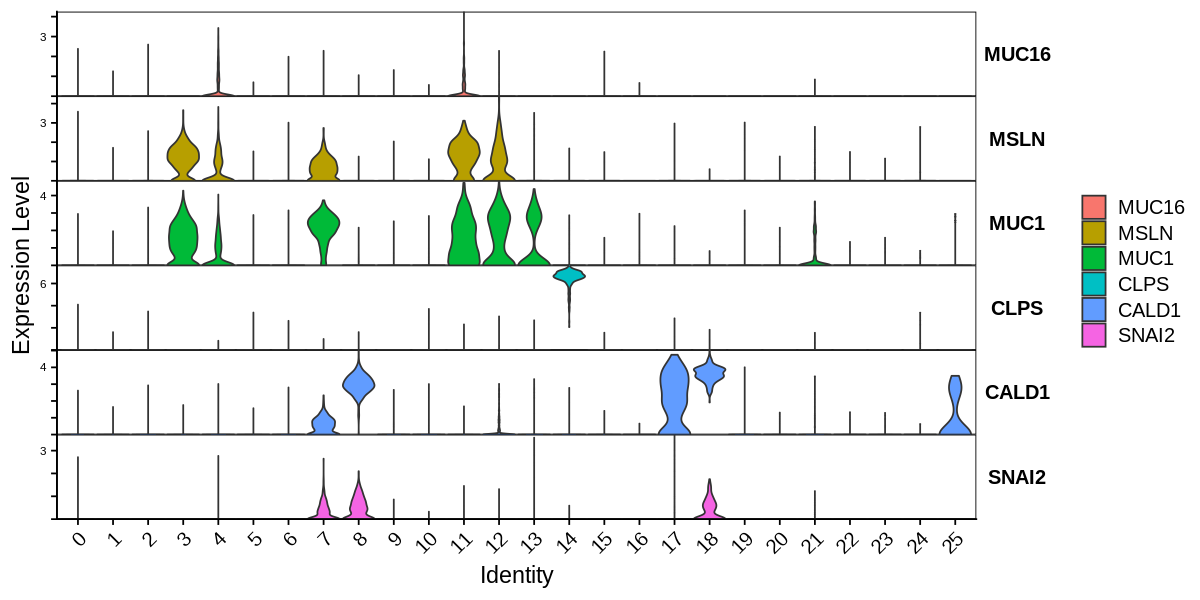

In [134]:
### Supplementary figure generated of expression of select markers across the clusters

VlnPlot(pbmc, features = c("MUC16", "MSLN", "MUC1", "CLPS", "CALD1", "SNAI2"), stack = T, flip = T)

In [135]:
pbb = pbmc


ERROR: Error: Cannot find 'umap' in this Seurat object


In [228]:
### Analysis of finding transcriptional differences between CALD1-exp myoepithelial cells against CDH1-exp epithelial cells
### We will use minimum expression cutoff

sc = pbb@assays$RNA@scale.data
idx2 = colnames(sc)[which(sc["CALD1",] > min(sc["CALD1", ]))]
idx3 = colnames(sc)[which(sc["CDH1",] > min(sc["CDH1", ]))]

int = setdiff(idx2,  idx3)
int2 = setdiff(idx3, idx2)
cluster5.markers <- FindMarkers(pbmc, ident.1 = int, ident.2 = int2, min.pct = 0.25)
head(cluster5.markers, 40)
length(int)
cluster5.markers <- FindMarkers(pbmc, ident.1 = int, ident.2 = int2, min.pct = 0.25)
head(cluster5.markers, 40)
length(int)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MXRA8,0,1.816296,0.587,0.021,0
SERINC2,0,-2.037780,0.153,0.867,0
TSPAN1,0,-1.985481,0.055,0.758,0
PDZK1IP1,0,-2.081759,0.069,0.785,0
TACSTD2,0,-2.815099,0.121,0.809,0
S100A14,0,-2.571442,0.073,0.835,0
F11R,0,-1.352038,0.122,0.781,0
ATP1B1,0,-2.037835,0.284,0.855,0
PRRX1,0,1.370349,0.516,0.000,0


[1] 1456

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MXRA8,0,1.816296,0.587,0.021,0
SERINC2,0,-2.037780,0.153,0.867,0
TSPAN1,0,-1.985481,0.055,0.758,0
PDZK1IP1,0,-2.081759,0.069,0.785,0
TACSTD2,0,-2.815099,0.121,0.809,0
S100A14,0,-2.571442,0.073,0.835,0
F11R,0,-1.352038,0.122,0.781,0
ATP1B1,0,-2.037835,0.284,0.855,0
PRRX1,0,1.370349,0.516,0.000,0


[1] 1456

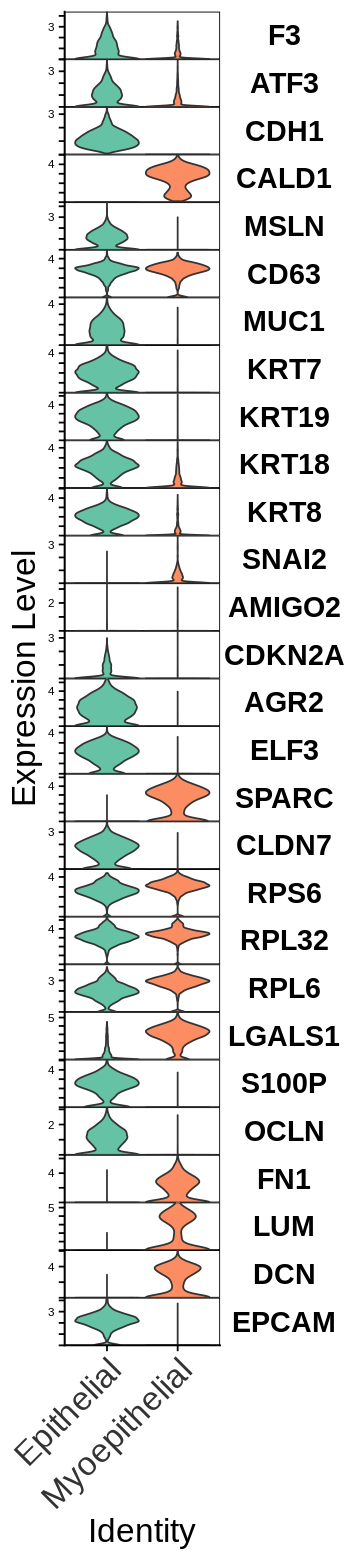

In [237]:
### Representing select markers across identified CALD1-exp myoepithelial and CDH1-exp epithelial cells

options(repr.plot.width=3, repr.plot.height=13)

pbb$orig.ident[int] = "Myoepithelial"
pbb$orig.ident[int2] = "Epithelial"


VlnPlot(subset(pbb, cells = c(int, int2)),features = c("F3",  "ATF3", "CDH1","CALD1", "MSLN", "CD63", "MUC1", "KRT7","KRT19", "KRT18", "KRT8", "SNAI2", "AMIGO2", "CDKN2A", "AGR2", "ELF3", "SPARC", "CLDN7", "RPS6", "RPL32", "RPL6", "KRT7", "LGALS1", "S100P", "OCLN", "FN1", "LUM", "DCN", "EPCAM"), group.by  = "orig.ident", stack = T, flip = T, split.by = "orig.ident", , cols = brewer.pal(3, "Set2")) +  theme(text = element_text(size = 20), axis.text.x = element_text(color = "grey20", size = 20)) + NoLegend() 

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Warning message in brewer.pal(2, "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”
Picking joint bandwidth of 0.0488

Picking joint bandwidth of 0.000501

Picking joint bandwidth of 0.0356

Picking joint bandwidth of 0.0107

Picking joint bandwidth of 0.0158

Picking joint bandwidth of 0.0338

Picking joint bandwidth of 0.0527

Picking joint bandwidth of 0.019

Picking joint bandwidth of 0.0447

Picking joint bandwidth of 0.0158

Picking joint bandwidth of 0.0226

Picking joint bandwidth of 0.0187

Picking joint bandwidth of 0.0175



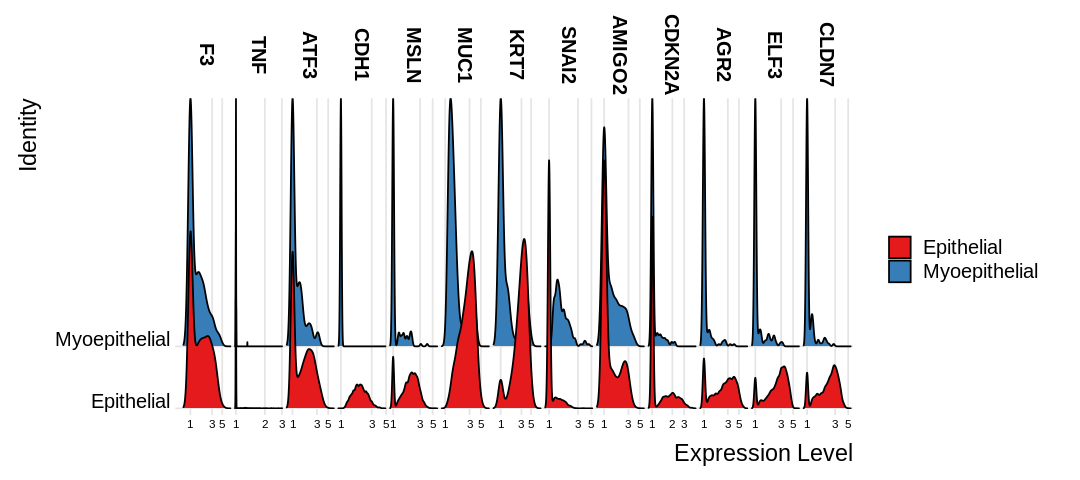

In [92]:
### Ridge plot similar to the violin plot made in the prior section

options(repr.plot.width=9, repr.plot.height=4)

p = RidgePlot(subset(pbb, cells = c(int, int2)),  group.by  = "orig.ident", features = c("F3", "TNF", "ATF3", "CDH1", "MSLN", "MUC1", "KRT7","SNAI2", "AMIGO2", "CDKN2A", "AGR2", "ELF3", "CLDN7"), stack = T, log = T, fill.by = "ident" , brewer.pal(2, "Set1"))

 +  theme(text = element_text(size = 20), axis.text.x = element_text(color = "grey20", size = 20)) + NoLegend() 

## MUC1 expressing cells showed high level of heterogeneity and therefore we will identify and characterize different subsets of MUC1-expressing cells using predefined markers


## Capturing mucin evolution arbitarily as lineage trajectory analysis failed to capture individual variations (not shown)

In [338]:
### Calculating cell proportions expressing below markers across the clusters for characterization (acinar, epithelial, mesenchymal or myoepithelial) 

genes = c("SNAI2", "CDH1", "CLPS", "CPS1", "VIM", "CALD1","MUC4", "MUC16", "MUC1", "MUC5AC", "MUC20", "MSLN")
ct2 = table(pbmc$seurat_clusters)

mat = matrix(0, length(genes), 26)
colnames(mat) = unique(pbmc$seurat_clusters)
rownames(mat) = genes
for(i in 1:length(genes)){
  ct = which(as.numeric(sc[genes[i], ]) > summary(as.numeric(sc[genes[i], ]))[2])
  ct = table(pbmc$seurat_clusters[ct])
  c11 = sort(ct/ct2[names(ct)])
  mat[i, names(c11)] = as.numeric(c11)
}

In [339]:
mat2 = mat


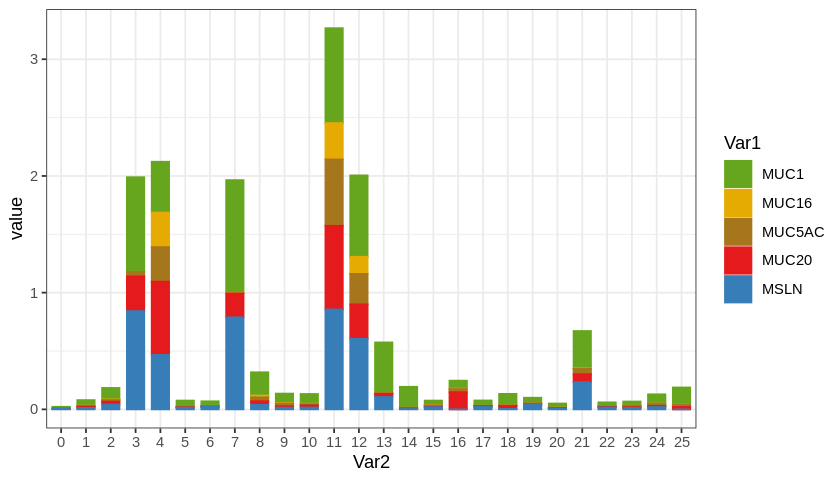

In [345]:
### Similar to high-level cell type characterization across the cluster, we estimated mucin-expressing cells across the clusters

options(repr.plot.width=7, repr.plot.height=4)

genes1 = c("MUC1", "MUC16", "MUC5AC", "MUC20", "MSLN")
mat = mat2[genes1, ]


mel  = melt(mat)

mel[,2] = as.character(mel[,2])



ggbarplot(mel, x = "Var2", y = "value",
  fill = "Var1", color = "Var1",
  palette = c(brewer.pal(7, "Dark2")[-c(1:4)], brewer.pal(4, "Set1")),
  label = F, lab.col = "white", order =sort(as.numeric(colnames(mat))))+ theme(legend.text=element_text(size=15), axis.text.x = element_text(size = 15,angle=90, hjust=1)) + theme_bw()


In [425]:

## The mucin expressing clusters showed variability in cell states/types, 
## therefore we attempted to recluster them and characterize metaplastic events if present. 
c = c("3","4","7","11","12", "21")
idd = c()
for(i in 1:length(c)){
    
idd = append(idd, names(pb$orig.ident[which(pb$seurat_clusters == c[i])]))}


    pbmc = subset(pb, cells = idd)
sc = pbmc@assays$RNA@scale.data

In [426]:
pbmc

An object of class Seurat 
32738 features across 4197 samples within 1 assay 
Active assay: RNA (32738 features, 2000 variable features)
 1 dimensional reduction calculated: pca

In [427]:
## using 1000 highly variable features for PCA due to small sample sizes

pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 1000)
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

pbmc <- FindNeighbors(pbmc, dims = 1:20)
pbmc <- FindClusters(pbmc, resolution = 0.5)
pbmc = RunUMAP(pbmc, dims = 1:20)
pbb = pbmc

Centering and scaling data matrix

PC_ 1 
Positive:  SPINK1, CYSTM1, CEACAM6, AGR2, TFF2, WFDC2, LGALS4, TFF1, DUOX2, ASS1 
	   CTSE, PRSS22, MACROD2, TFF3, GDF15, DDIT3, PDE4C, DUOXA2, FAM3D, PSCA 
	   MUC4, CEACAM7, CLU, APOL1, ANXA4, MUC17, PLAC8, DUSP5, DHRS9, CXCL17 
Negative:  MKI67, ASPM, NUSAP1, PTPRC, GMFG, TOP2A, CENPF, CDK1, VIM, GTSE1 
	   TYMS, CASC5, SRGN, KIFC1, AURKB, CORO1A, BIRC5, CELF2, CENPE, TPX2 
	   UBE2C, LCP1, CD53, LSP1, CD52, BUB1B, DLGAP5, LAPTM5, PTPRCAP, NUF2 
PC_ 2 
Positive:  MT-CO2, SPINK1, LYZ, TFF2, CEACAM6, CYSTM1, TFF1, CTSE, WFDC2, PLAC8 
	   AGR2, DUOX2, MACROD2, LGALS4, MUC17, TFF3, FAM3D, DUOXA2, ASS1, MUC4 
	   HSD17B2, DPCR1, FBP1, PIGR, HLA-DRB1, PSCA, ISG20, GSTM3, GPX2, RP11-1143G9.4 
Negative:  DCBLD2, LAMB1, LGALS1, FERMT1, CNTNAP2, MAP1B, TGM2, ITGB6, IGFBP6, HMGA2 
	   TGFBI, GPC6, PLAU, CALD1, RBP1, PODXL, ID1, CDH11, C2orf82, CRABP2 
	   IGFBP7, ZMAT3, NR2F1, DEFB1, TNS4, KRT16, TRIM54, S100A2, EFEMP1, SERPINE2 
PC_ 3 
Positive:  SERP

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4197
Number of edges: 148335

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8901
Number of communities: 13
Elapsed time: 0 seconds


10:44:56 UMAP embedding parameters a = 0.9922 b = 1.112

10:44:56 Read 4197 rows and found 20 numeric columns

10:44:56 Using Annoy for neighbor search, n_neighbors = 30

10:44:56 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:44:56 Writing NN index file to temp file /tmp/Rtmpp0jstJ/filef9136f19fcc

10:44:56 Searching Annoy index using 1 thread, search_k = 3000

10:44:57 Annoy recall = 100%

10:44:58 Commencing smooth kNN distance calibration using 1 thread

10:44:59 Initializing from normalized Laplacian + noise

10:44:59 Commencing optimization for 500 epochs, with 171552 positive edges

10:45:10 Optimization finished



[1] 32738  4197

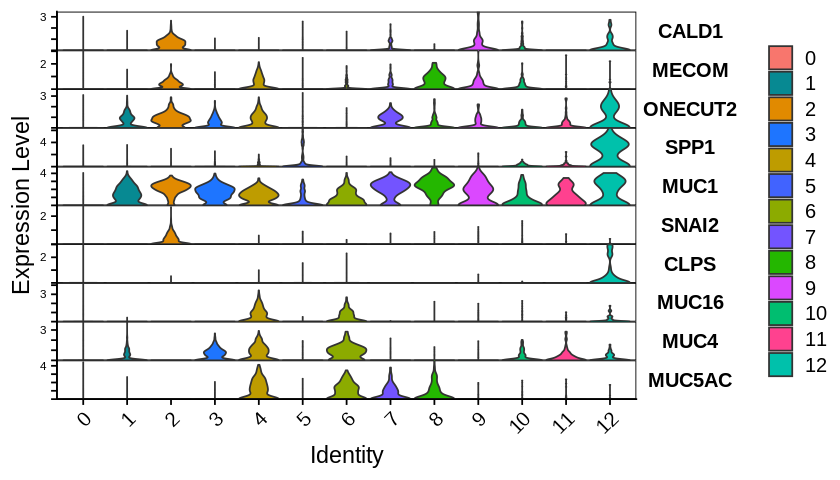

In [440]:
#### Reclustering revealed 12 clusters with variable expression of mucins, metaplastic markers (ONECUT2, MECOM) and mesenchymal/myoepithelial markers. 
####
dim(pbmc)

options(repr.plot.width=7, repr.plot.height=4)

VlnPlot(pbmc, features = c("CALD1", "MECOM", "ONECUT2", "SPP1", "MUC1", "SNAI2", "CLPS", "MUC16", "MUC4", "MUC5AC"), stack = T, pt.size = 0,  split.by = "seurat_clusters", flip = T)

In [446]:

### Arbitary estimation of cell proportions expressing select markers

sc = pbmc@assays$RNA@scale.data
dim(sc)

length(which(sc["CALD1", ] > min(sc["CALD1", ])))/ncol(sc)
length(which(sc["SNAI2", ] > min(sc["SNAI2", ])))/ncol(sc)
length(which(sc["TGFB1", ] > min(sc["TGFB1", ])))/ncol(sc)
length(which(sc["ONECUT2", ] > min(sc["ONECUT2", ])))/ncol(sc)
length(which(sc["MECOM", ] > min(sc["MECOM", ])))/ncol(sc)
length(which(sc["CPS1", ] > min(sc["CPS1", ])))/ncol(sc)

table(pbmc$seurat_clusters)

[1] 32738  4197

[1] 0.1822731

[1] 0.108649

[1] 0.347391

[1] 0.4696212

[1] 0.3033119

[1] 0.01143674


  0   1   2   3   4   5   6   7   8   9  10  11  12 
687 676 669 608 432 209 201 164 149 136 126  80  60 

In [441]:
dim(pbmc)

[1] 32738  4197

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12



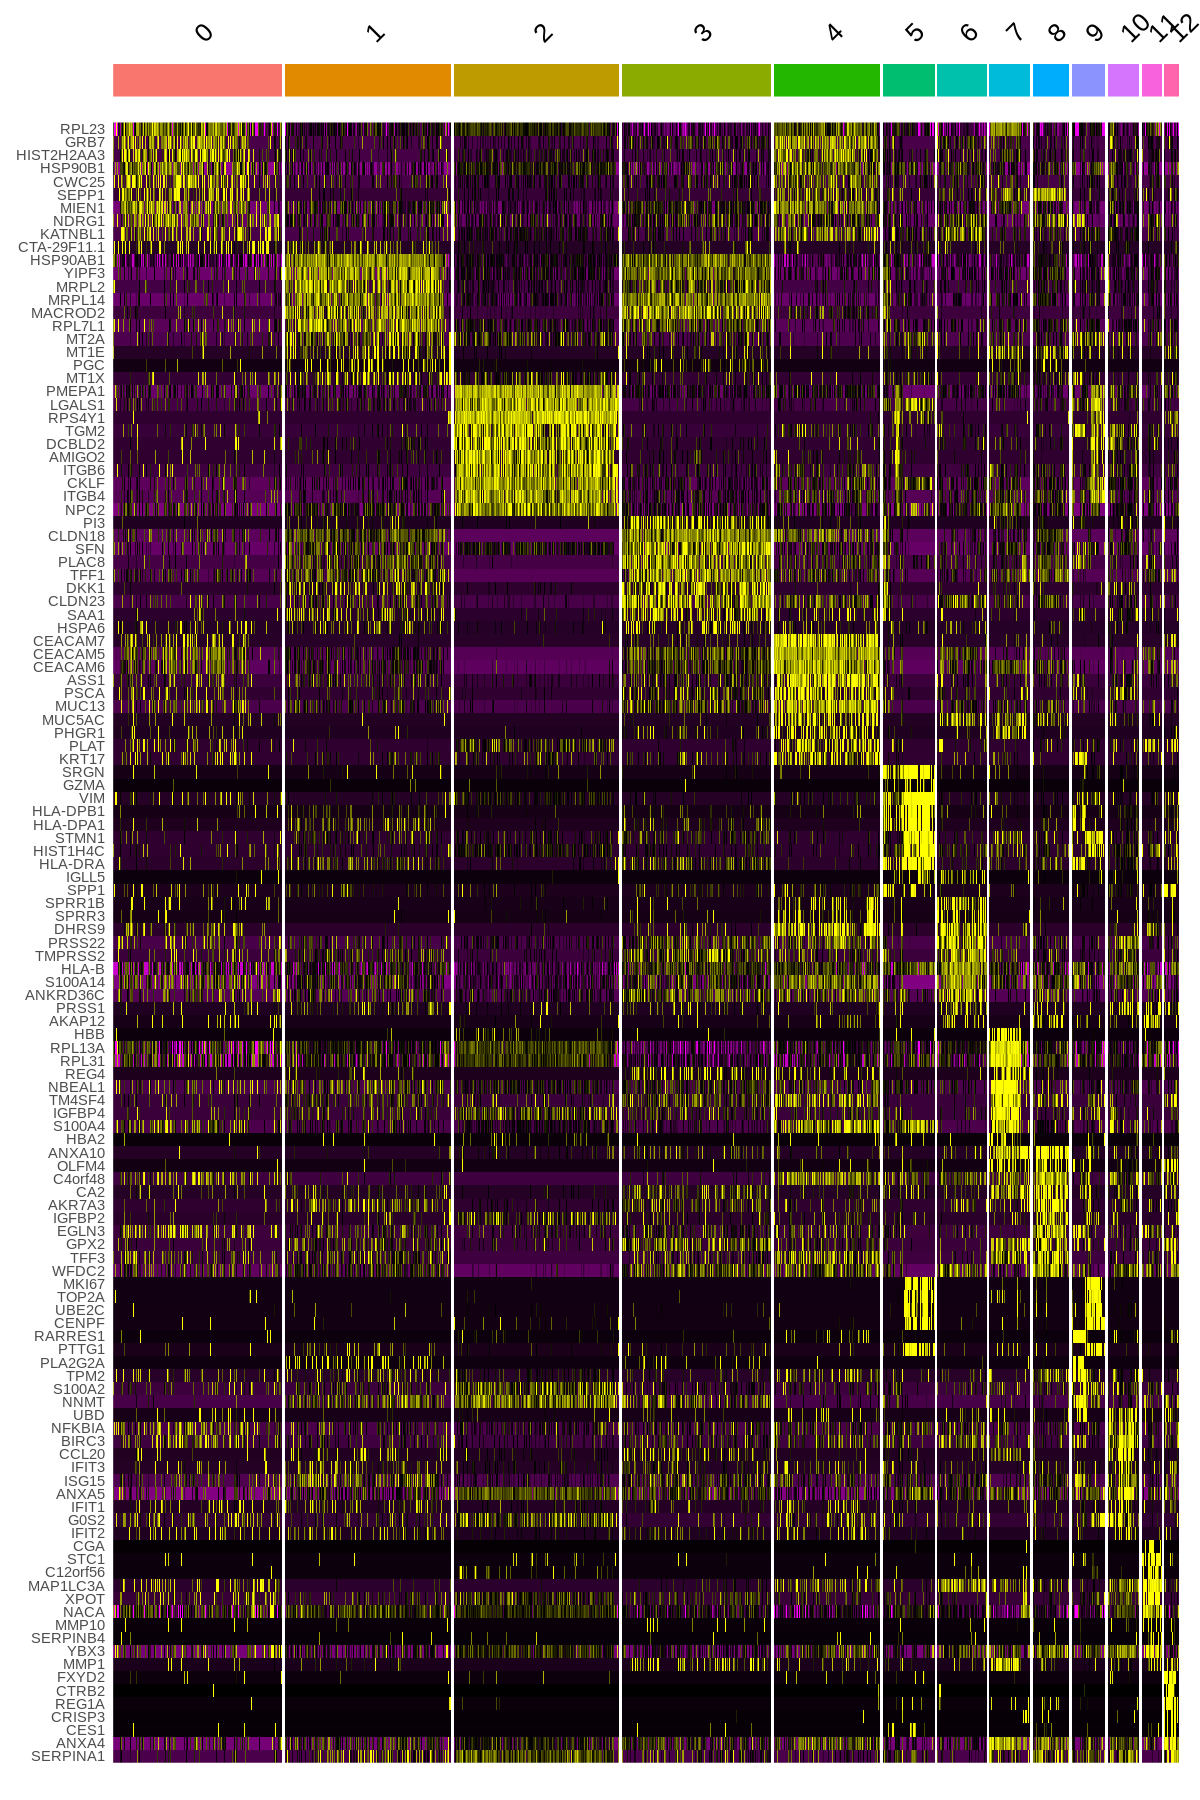

In [438]:
### The heatmap representation of top 10 differentially expression markers of the reclusters

options(repr.plot.width=10, repr.plot.height=15)
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

pbmc.markers %>%
    group_by(cluster) %>%
    top_n(n = 10, wt = avg_log2FC) -> top10
DoHeatmap(pbmc, features = top10$gene) + NoLegend()

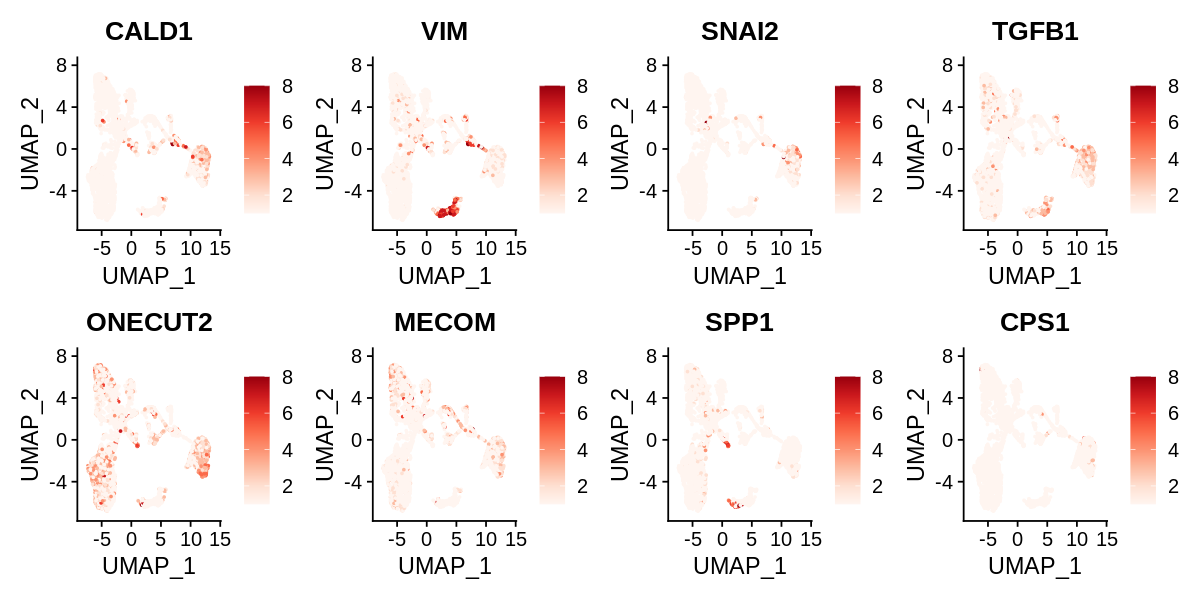

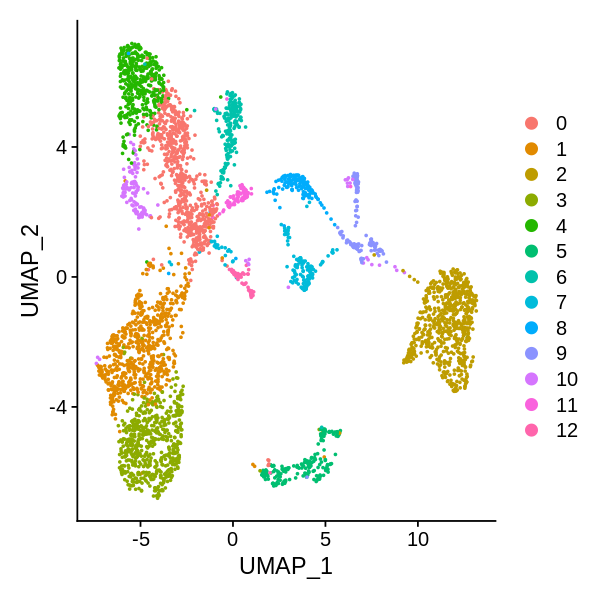

In [447]:
### UMAP representation of select markers to show their variable abundance across multiple cell clusters

options(repr.plot.width = 10, repr.plot.height=5)

FeaturePlot(pbmc, features = c("CALD1", "VIM", "SNAI2", "TGFB1", "ONECUT2", "MECOM", "SPP1", "CPS1"), cols = brewer.pal(8, "Reds"), ncol = 4)

options(repr.plot.width=5, repr.plot.height=5)
DimPlot(pbmc, reduction = "umap")

Warning message in rownames(mat):
“NaNs produced”


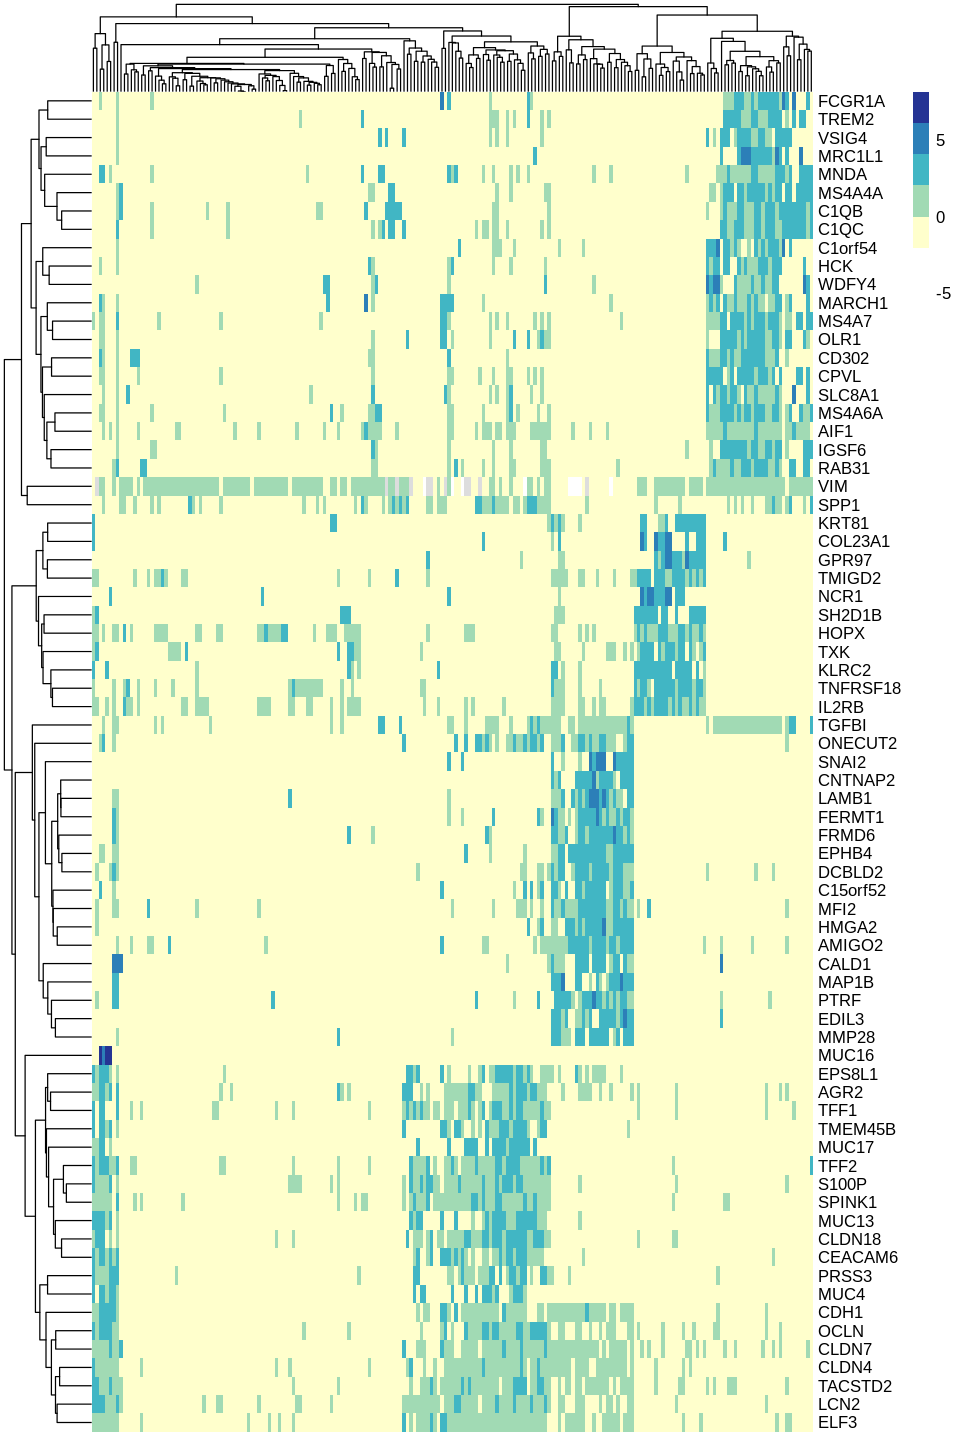

In [32]:
#### we observe a myoepithelial phenotype bridging mesenchymal to ductal switch in cluster 5 (only considering cluster 5)
## the heatmap clearly shows distinct cluster subpopulations variably expressing the myeloid, epithelial and mesenchymal markers

idd = names(pbmc$orig.ident[which(pbmc$seurat_clusters== 5)])
tempst =sc[, idd]
l = read.csv("~/Untitled 1_markers.csv", header= T, stringsAsFactors = F)
options(repr.plot.width=8, repr.plot.height=12)
pheatmap(log2(tempst[c(l[,1], "MUC16", "MUC4", "CDH1", "ONECUT2", "CALD1", "TGFBI"), ]+1), scale = 'row', show_colnames = F, col = c("white", "white", "white", brewer.pal(5, "YlGnBu")))


Warning message in rownames(mat):
“NaNs produced”


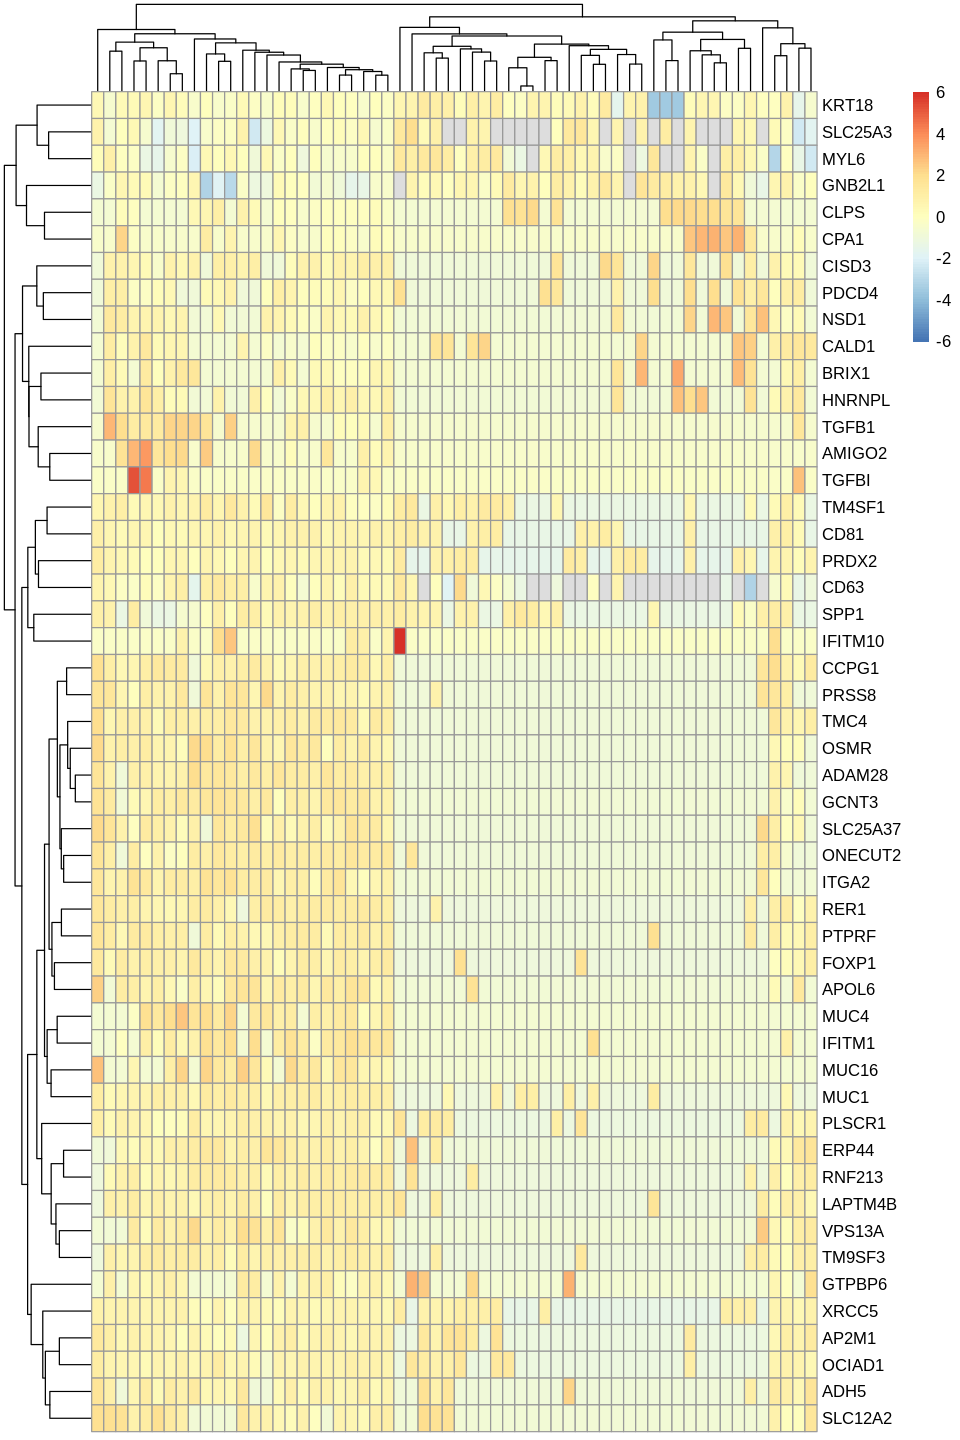

In [37]:
##### Similar to above we observed switch from acinar to ductal in the acinar cell cluster (cluster 12)
### Although metaplastic markers are overexpressed in acinar cluster, the small sample size (cells = 60) caused uncertainity.

adm = l$ADM
adm  = adm[which(adm != "")]

idd = names(pbmc$orig.ident[(which(pbmc$seurat_clusters == 12))])
tempst =sc[, idd]

options(repr.plot.width=8, repr.plot.height=12)
pheatmap(log2(tempst[c(unique(adm), 
"TGFBI",
"IFITM10", "CALD1"),
]+1),scale ="row", show_colnames  = F)

In [453]:
### Subseting just MUC1-expressing cells as they are the predominant mucin-expressing cells are found to be expressed by multiple cell types
pbb = pbmc
sc = pbb@assays$RNA@scale.data
idx = colnames(sc)[which(sc["MUC1",] > min(sc["MUC1", ]))]

pbmc =subset(pbb, cells = idx)

scc = pbmc@assays$RNA@scale.data

[1] 0.6978794

In [458]:
### we will use SNAI2 alongside MUC1 to identify myoepithelial/mesenchymal MUC1-expressing cells. 
### Using CALD1 instead of SNAI2 show also give similar results due to their co-expression. CALD1 is considered marker of SMC differentiation and Myoepithelial cells. 


idxx2 = colnames(scc)[which(scc["MUC1",] > min(scc["MUC1", ]))]

idxx3 = colnames(scc)[which(scc["SNAI2",] > min(scc["SNAI2", ]))]

int= intersect(idxx2, idxx3)
length(int)

[1] 360

In [459]:
### Characterize MUC1 expressing cells and stratify them into different subgroups (myoepithelial, intermediate/other, differentiated cells (based on MUC4, MUC5AC and MUC16 expression )
### 70% of all mucin expressing cells (MUC4, 5ac, 16, 20) express MUC1 and therefore we try to find what differentiates these epithelial cells.  
idxx2 = colnames(scc)[which(scc["MUC1",] > min(scc["MUC1", ]))]

idxx3 = colnames(scc)[which(scc["SNAI2",] > min(scc["SNAI2", ]))]

int= intersect(idxx2, idxx3)

idxx2 = colnames(scc)[which(scc["MUC1",] > min(scc["MUC1", ]))]

idxx3 = colnames(scc)[which(scc["MUC4",] > min(scc["MUC4", ]))]

int2= intersect(idxx2, idxx3)
idxx2 = colnames(scc)[which(scc["MUC1",] > min(scc["MUC1", ]))]

idxx3 = colnames(scc)[which(scc["MUC16",] > min(scc["MUC16", ]))]

int3= intersect(idxx2, idxx3)

idxx2 = colnames(scc)[which(scc["MUC1",] > min(scc["MUC1", ]))]

idxx3 = colnames(scc)[which(scc["MUC20",] > min(scc["MUC20", ]))]

int4= intersect(idxx2, idxx3)


idxx2 = colnames(scc)[which(scc["MUC1",] > min(scc["MUC1", ]))]

idxx3 = colnames(scc)[which(scc["MUC5AC",] > min(scc["MUC5AC", ]))]

int5= intersect(idxx2, idxx3)


int = setdiff(int, c(int2, int3, int4, int5))
int2 = setdiff(int2, c(int, int3, int4, int5))
int4 = setdiff(int4, c(int2, int3, int, int5))
int5 = setdiff(int5, c(int2, int3, int4, int))
int3= setdiff(int3, c(int2, int, int4, int5))

other = setdiff( colnames(scc), c(int, int2, int3, int4, int5))


cluster1.markers <- FindMarkers(pbmc, ident.1 = int, ident.2 = c(int2, int3, int4, int5, other), min.pct = 0.25, only.pos = T)
cluster2.markers <- FindMarkers(pbmc, ident.1 = int2, ident.2 = c(int, int3, int4, int5, other), min.pct = 0.25, only.pos = T)
cluster3.markers <- FindMarkers(pbmc, ident.1 = int3, ident.2 = c(int2, int, int4, int5, other), min.pct = 0.25,only.pos = T)
cluster4.markers <- FindMarkers(pbmc, ident.1 = int4, ident.2 = c(int2, int3, int, int5, other), min.pct = 0.25, only.pos = T)
cluster5.markers <- FindMarkers(pbmc, ident.1 = int5, ident.2 = c(int2, int3, int4, int, other), min.pct = 0.25,only.pos = T)
otherr <- FindMarkers(pbmc, ident.1 = other, ident.2 = c(int2, int3, int4, int5, int), min.pct = 0.25,only.pos = T)

c = c(rownames(cluster1.markers)[1:5],rownames(cluster2.markers)[1:5], rownames(cluster3.markers)[1:10],rownames(cluster4.markers)[1:5], rownames(cluster5.markers)[1:5], rownames(otherr)[1:5])

[1] 32738  4197

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Picking joint bandwidth of 0.00453

Picking joint bandwidth of 0.00637

Picking joint bandwidth of 0.00618

Picking joint bandwidth of 0.00627

Picking joint bandwidth of 0.0115

Picking joint bandwidth of 0.0256

Picking joint bandwidth of 0.028

Picking joint bandwidth of 0.0323

Picking joint bandwidth of 0.0371

Picking joint bandwidth of 0.0308

Picking joint bandwidth of 0.00637

Picking joint bandwidth of 0.0144

Picking joint bandwidth of 0.0206

Picking joint bandwidth of 0.00913

Picking joint bandwidth of 0.0217

Picking joint bandwidth of 0.0164

Picking joint bandwidth of 0.0207

Picking joint bandwidth of 0.0224

Picking joint bandwidth of 0.0101

Picking joint bandwidth of 0.00889

Picking joint bandwidth of 0.0212

Picking joint bandwidth of 0.0264

Picking joint bandwidth of 0.0258

Picking joint bandwidth of 0.0164

Picking joint bandwidth of 0.0177

Picking joint b

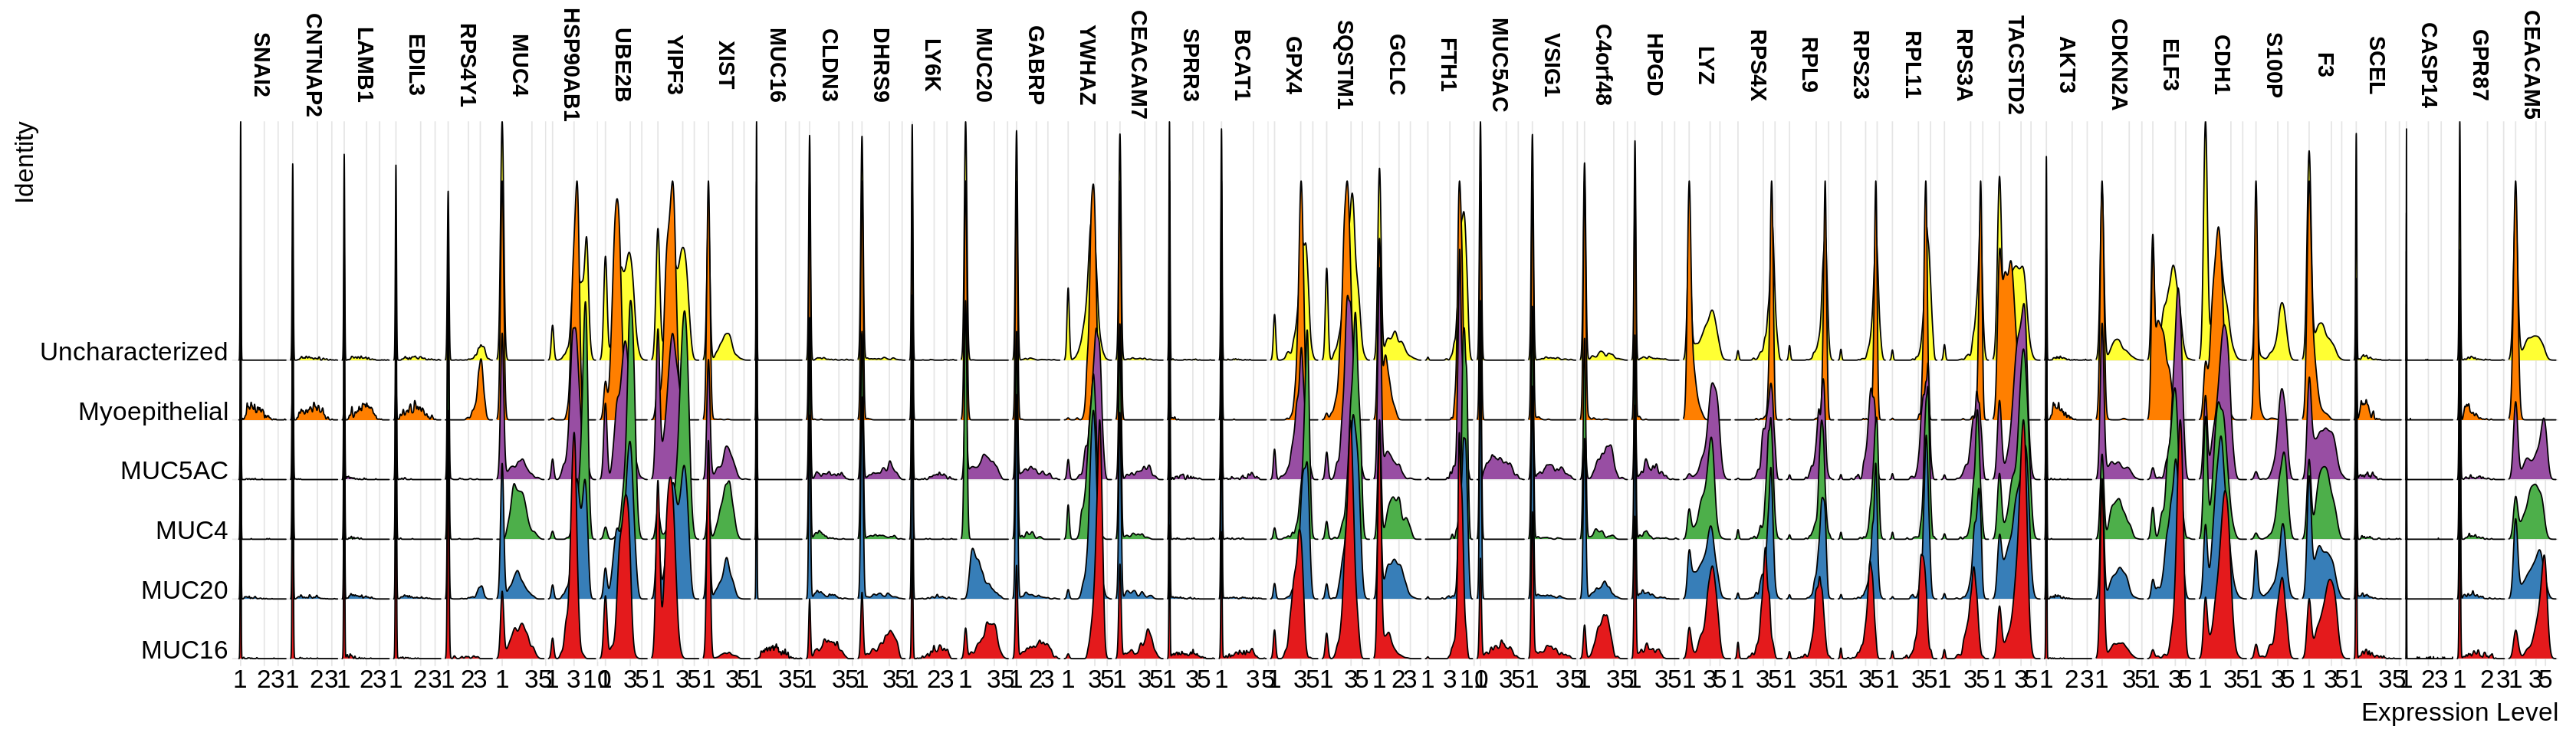

In [461]:
### we have used select markers of each of these cell groups for representation using ridge plot.
### MUC16-exp cells show overexpression of squamous and cell-adhesion markers.

testpb = pbmc

options(repr.plot.width = 28, repr.plot.height=8)


testpb$orig.ident[int] = "Myoepithelial"

testpb$orig.ident[int2] = "MUC4"
testpb$orig.ident[int3] = "MUC16"
testpb$orig.ident[int4] = "MUC20"
testpb$orig.ident[int5] = "MUC5AC"
testpb$orig.ident[other] = "Uncharacterized"
                  
c = unique(c(c, "TACSTD2", "AKT3", "YWHAZ", "CDKN2A", "ELF3", "CDH1", "S100P", "F3", "SCEL", "CASP14", "GPR87", "CEACAM5"))

p = RidgePlot(subset(testpb, cells = c(int, int2, int3, int4, int5, other)),  group.by  = "orig.ident", features = c(c), stack = T, log = T, fill.by = "ident" , brewer.pal(6, "Set1"))

 p +  theme(text = element_text(size = 20), axis.text.x = element_text( size = 20), axis.text.y = element_text( size = 20)) + NoLegend()               


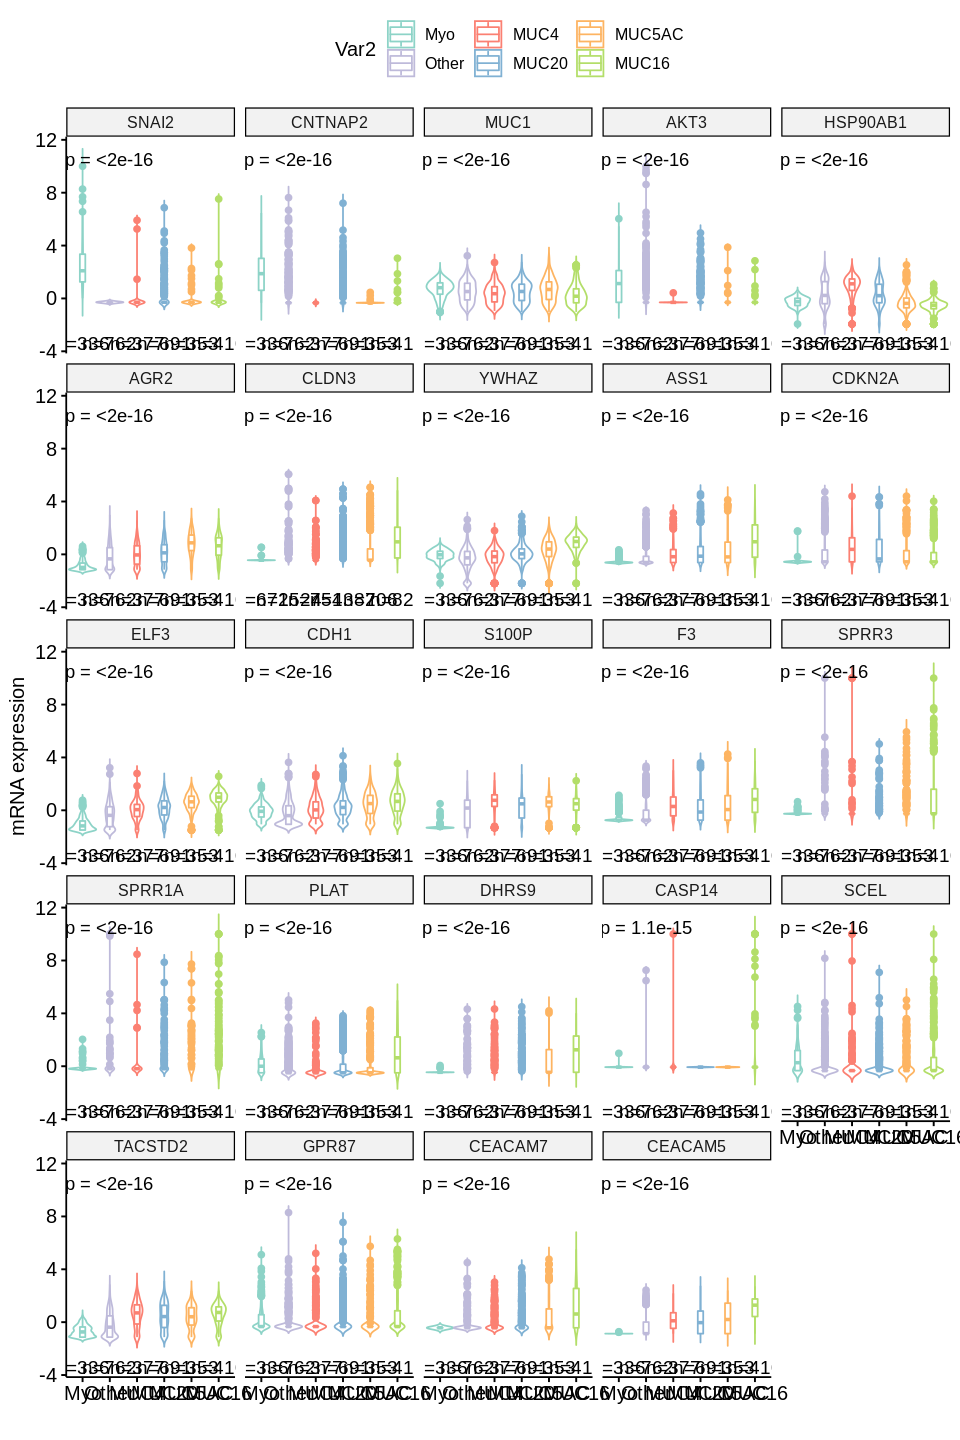

In [42]:
### Similar to above we will make boxplots of different predefined markers using ggpubr package (not used in the manuscript)

cto= c( "SNAI2", "CNTNAP2", "MUC1", "AKT3", "HSP90AB1", "AGR2", "CLDN3", "YWHAZ", "ASS1", "CDKN2A",  "ELF3", "CLDN3", "CDH1", "S100P", "F3", "SPRR3", "SPRR1A", "PLAT", "DHRS9", "CASP14", "SCEL", "TACSTD2", "GPR87", "CEACAM7", "CEACAM5")
 palette = brewer.pal(9, "Set3")[-2]
temp = scc[cto, ]
colnames(temp) = df[,1]
mel = melt(temp)
mel[,2] = factor(mel[,2], levels =c("Myo", "Other", "MUC4",  "MUC20", "MUC5AC","MUC16"))
p = ggviolin(mel, y = "value", x = "Var2",color = "Var2", palette = palette, ylab = "mRNA expression", xlab = "", add = "boxplot")
p = facet(p, facet.by = "Var1", nrow = 5, ncol = 5)
p = p + stat_compare_means( label = "p.format")
p = p +stat_n_text()
p
ggsave( "test.pdf",p, width = 10, height = 20)

In [504]:
### estimating correlations between proportions of cells expressing mucins across all ~16000 PDAC cells

sc = pb@assays$RNA@scale.data
ct2 =table(pb$orig.ident)
genes = rownames(sc)[grep("MUC[0-9]+", rownames(sc))]
mat = matrix(0, length(genes), 15)
colnames(mat) = unique(pb$orig.ident)
rownames(mat) = genes
for(i in 1:length(genes)){
  ct = which(as.numeric(sc[genes[i], ]) > summary(as.numeric(sc[genes[i], ]))[5])
  ct = table(pb$orig.ident[ct])
  c11 = sort(ct/ct2[names(ct)])
  mat[i, names(c11)] = as.numeric(c11)
}

Warning message in (function (kind = NULL, normal.kind = NULL, sample.kind = NULL) :
“non-uniform 'Rounding' sampler used”


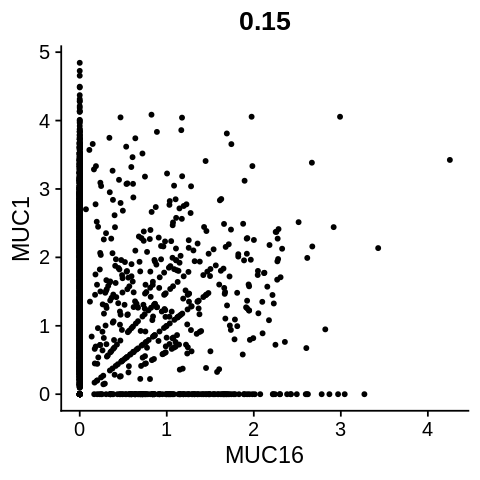

In [481]:
### scatter plot of correlation between MUC1 and MUC16 mRNA across all PDAC cells.

options(repr.plot.width = 4, repr.plot.height=4)

FeatureScatter(pb, feature1 = "MUC16", feature2 = "MUC1", cols = rep("Black", 30), plot.cor = )+NoLegend()

In [506]:
mat = t(mat)


,MUC1,MUC13,MUC20,MUC4,MUC7,MUC21,MUC22,MUC3A,MUC3A.1,MUC12,MUC17,MUC6,MUC2,MUC5AC,MUC5B,MUC15,MUC19,MUC8,MUC16
PDAC_TISSUE_1,0.22554348,0.103260870,0.02173913,0.029891304,0,0.0054347826,0.0000000000,0.01086957,0,0.010869565,0.000000000,0.0760869565,0.000000000,0.01358696,0.1222826087,0.000000000,0.0000000000,0,0.0733695652
PDAC_TISSUE_10,0.02692998,0.000000000,0.02333932,0.000000000,0,0.0000000000,0.0000000000,0.00000000,0,0.003590664,0.000000000,0.0000000000,0.000000000,0.00000000,0.0000000000,0.000000000,0.0000000000,0,0.0000000000
PDAC_TISSUE_12,0.10810811,0.001689189,0.08277027,0.005067568,0,0.0016891892,0.0016891892,0.00000000,0,0.018581081,0.000000000,0.0084459459,0.000000000,0.03040541,0.0016891892,0.000000000,0.0000000000,0,0.0016891892
PDAC_TISSUE_13,0.39468691,0.281151170,0.12776724,0.213788741,0,0.0003162555,0.0003162555,0.03921569,0,0.201771031,0.243833017,0.0003162555,0.001897533,0.01518027,0.0009487666,0.000000000,0.0003162555,0,0.0003162555
PDAC_TISSUE_15,0.22709924,0.034351145,0.12786260,0.049618321,0,0.0095419847,0.0000000000,0.01526718,0,0.104961832,0.003816794,0.0114503817,0.000000000,0.02671756,0.0019083969,0.001908397,0.0000000000,0,0.0400763359
PDAC_TISSUE_16,0.63265306,0.351020408,0.06938776,0.036734694,0,0.0040816327,0.0000000000,0.04081633,0,0.073469388,0.053061224,0.4408163265,0.004081633,0.38367347,0.4530612245,0.000000000,0.0000000000,0,0.0000000000


In [533]:
### melt dataframe of cell proportions of mucin-expressing cells and observe correlations with MUC1-exp cell proportions

mat2 = mat[, c('MUC20', "MUC16", "MUC4", "MUC5AC", "MUC1")]
mel = melt(mat2[, 1:4])
new_mel = cbind(mel, MUC1 = mat2[mel[,1], 5])

`geom_smooth()` using formula 'y ~ x'



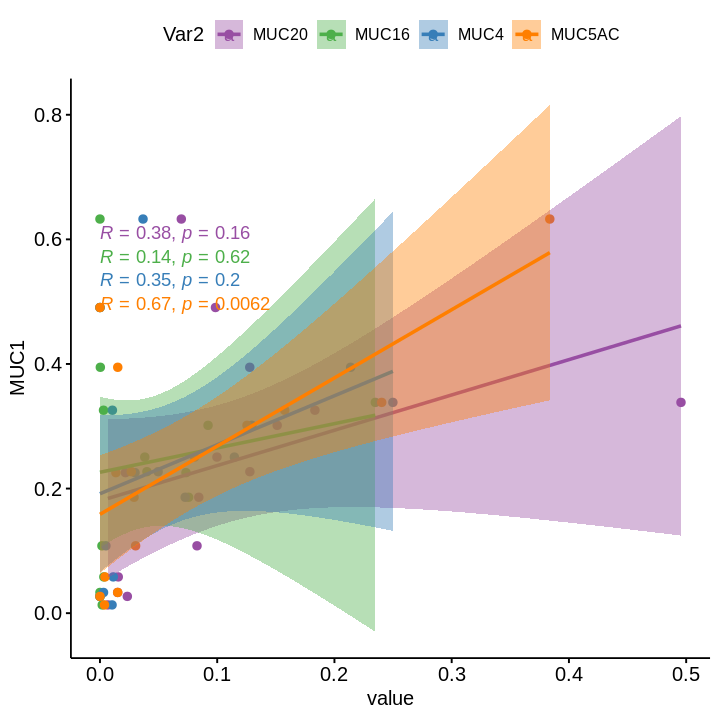

In [539]:
### Correlations show strong correlation between MUC1 and MUC5AC-exp cells across PDAC patients.

options(repr.plot.width = 6, repr.plot.height=6)

ggscatter(new_mel, x = "value", y = "MUC1",
          add = "reg.line",                         # Add regression line
          conf.int = TRUE,                          # Add confidence interval
          color = "Var2", palette = brewer.pal(6, "Set1")[c(4,3,2,5)]           # Color by groups "cyl                            # Change point shape by groups "cyl"
          )+
  stat_cor(aes(color = Var2))   

In [541]:
### estimate cell proportions to see if MUC1-exp is neeeded for other mucin expressing cells across all PDAC cells
idx = which(sc["MUC1", ] > min(sc["MUC1", ]))
idx2 = which(sc["MUC16", ] > min(sc["MUC16", ]))
idx3 = which(sc["MUC4", ] > min(sc["MUC4", ]))
idx4 = which(sc["MUC5AC", ] > min(sc["MUC5AC", ]))
idx4 = which(sc["MUC20", ] > min(sc["MUC20", ]))

length(setdiff(idx5, idx))/length(idx5)

ERROR: Error in setdiff(idx5, idx): object 'idx5' not found


In [550]:
### we will use MUC1 and MUC16 protein expression across 18 PDAC CCLE cell lines to see if MUC1 expressing cell lines only express MUC16 expression

[1] 0.2977018

In [568]:
### protein data download from DepMap or CCLE (https://depmap.org/portal/download/)
mart = read.csv("~/Downloads/protein_quant_current_normalized.csv",  stringsAsFactors = F, check.names = F, header = T, row.names = 1)
head(mart)
mart[grep("PANC", colnames(mart)),]
idx = grep("PANC", colnames(mart))
m = mart[, idx]
head(m)
grep("MUC1_", rownames(m
))
mart[c(7028, 8855), idx]
mt = mart[c(7028, 8855), idx]

,Gene_Symbol,Description,Group_ID,Uniprot,Uniprot_Acc,TenPx01_Peptides,TenPx02_Peptides,TenPx03_Peptides,TenPx04_Peptides,TenPx06_Peptides,⋯,NCIH2030_LUNG_TenPx18,22RV1_PROSTATE_TenPx24,A172_CENTRAL_NERVOUS_SYSTEM_TenPx24,BT20_BREAST_TenPx24,CALU6_LUNG_TenPx24,FADU_UPPER_AERODIGESTIVE_TRACT_TenPx24,KP4_PANCREAS_TenPx24,MONOMAC6_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE_TenPx24,OVCAR8_OVARY_TenPx24,THP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE_TenPx24
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sp|P55011|S12A2_HUMAN,SLC12A2,S12A2_HUMAN Solute carrier family 12 member 2,0,S12A2_HUMAN,P55011,41,16,23,59,44,⋯,-1.34502374,1.8112046,-0.9211763,-1.0457274,0.8455742,-0.07106337,0.7023063,-1.3958777,-1.1650323,-0.5475356
sp|P35453|HXD13_HUMAN,HOXD13,HXD13_HUMAN Homeobox protein Hox-D13,1,HXD13_HUMAN,P35453,0,0,0,0,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
sp|O60341|KDM1A_HUMAN,KDM1A,KDM1A_HUMAN Lysine-specific histone demethylase 1A,2,KDM1A_HUMAN,O60341,25,35,37,40,33,⋯,0.16119635,-0.3379936,-0.4556013,0.3923927,0.2583799,-0.81724470,-0.7900099,0.9295221,-0.8287363,0.7354308
sp|O00570|SOX1_HUMAN,SOX1,SOX1_HUMAN Transcription factor SOX-1,4,SOX1_HUMAN,O00570,0,0,1,0,0,⋯,-0.04019759,NA,NA,NA,NA,NA,NA,NA,NA,NA
sp|P48431|SOX2_HUMAN,SOX2,SOX2_HUMAN Transcription factor SOX-2,4,SOX2_HUMAN,P48431,1,0,2,1,2,⋯,-4.62760574,-1.2617033,1.1368510,-3.1790270,1.4245698,2.54968670,4.4240947,-1.0836981,-1.6409900,-2.9055469
sp|P41225|SOX3_HUMAN,SOX3,SOX3_HUMAN Transcription factor SOX-3,4,SOX3_HUMAN,P41225,0,0,0,0,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


,Gene_Symbol,Description,Group_ID,Uniprot,Uniprot_Acc,TenPx01_Peptides,TenPx02_Peptides,TenPx03_Peptides,TenPx04_Peptides,TenPx06_Peptides,⋯,NCIH2030_LUNG_TenPx18,22RV1_PROSTATE_TenPx24,A172_CENTRAL_NERVOUS_SYSTEM_TenPx24,BT20_BREAST_TenPx24,CALU6_LUNG_TenPx24,FADU_UPPER_AERODIGESTIVE_TRACT_TenPx24,KP4_PANCREAS_TenPx24,MONOMAC6_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE_TenPx24,OVCAR8_OVARY_TenPx24,THP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE_TenPx24
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sp|Q9H694|BICC1_HUMAN,BICC1,BICC1_HUMAN Protein bicaudal C homolog 1,45,BICC1_HUMAN,Q9H694,10,9,0,0,7,⋯,2.69039873,NA,NA,NA,NA,NA,NA,NA,NA,NA
sp|P09543|CN37_HUMAN,CNP,"CN37_HUMAN 2',3'-cyclic-nucleotide 3'-phosphodiesterase",72,CN37_HUMAN,P09543,34,43,29,34,28,⋯,1.15764235,-0.42955125,1.0778200953,0.949745785,-0.3345267834,-0.9093726,-0.64707298,-0.02500569,-0.57729568,-0.169093694
sp|Q13242|SRSF9_HUMAN,SRSF9,SRSF9_HUMAN Serine/arginine-rich splicing factor 9,77,SRSF9_HUMAN,Q13242,28,31,31,24,28,⋯,0.32973675,1.35521643,-1.0937899051,-0.848467924,0.1828585317,1.1960793,1.73732977,-0.78030823,-0.19455701,-0.372770233
sp|Q02880|TOP2B_HUMAN,TOP2B,TOP2B_HUMAN DNA topoisomerase 2-beta,83,TOP2B_HUMAN,Q02880,93,83,95,93,118,⋯,0.20691647,-0.41331567,-0.3838427339,-0.010527673,-0.4325878308,-0.9813969,-0.53703241,1.88183566,-1.12312899,0.712392209
sp|Q14185|DOCK1_HUMAN,DOCK1,DOCK1_HUMAN Dedicator of cytokinesis protein 1,86,DOCK1_HUMAN,Q14185,17,13,7,17,8,⋯,-0.26240179,-0.27612518,-0.3617638460,-0.470719389,0.0005234057,0.2270912,0.98628639,0.73470485,0.17863794,-1.398013897
sp|P13497|BMP1_HUMAN,BMP1,BMP1_HUMAN Bone morphogenetic protein 1,92,BMP1_HUMAN,P13497,1,1,0,0,2,⋯,-0.86136985,NA,NA,NA,NA,NA,NA,NA,NA,NA
sp|Q96C19|EFHD2_HUMAN,EFHD2,EFHD2_HUMAN EF-hand domain-containing protein D2,105,EFHD2_HUMAN,Q96C19,23,38,37,30,19,⋯,-0.14367878,-1.64383998,-1.1475140380,-0.203584742,0.0377310640,2.0148027,0.47273575,0.85775301,-0.48745472,1.289789032
sp|P30837|AL1B1_HUMAN,ALDH1B1,"AL1B1_HUMAN Aldehyde dehydrogenase X, mitochondrial",135,AL1B1_HUMAN,P30837,25,46,27,34,39,⋯,-2.10857749,-0.40361659,0.2065143334,0.624991874,0.6331109254,0.3476019,0.72513266,-1.05901408,-0.27147371,-0.214438646
tr|H0Y931|H0Y931_HUMAN,ANK2,H0Y931_HUMAN Ankyrin-2 (Fragment),145,H0Y931_HUMAN,H0Y931,1,1,0,0,2,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


,PATU8988T_PANCREAS_TenPx03,TCCPAN2_PANCREAS_TenPx09,MIAPACA2_PANCREAS_TenPx10,QGP1_PANCREAS_TenPx11,SU8686_PANCREAS_TenPx12,CFPAC1_PANCREAS_TenPx13,L33_PANCREAS_TenPx17,SW1990_PANCREAS_TenPx22,ASPC1_PANCREAS_TenPx29,KP2_PANCREAS_TenPx36,PANC1_PANCREAS_TenPx37,DANG_PANCREAS_TenPx39,PANC0403_PANCREAS_TenPx40,PANC0203_PANCREAS_TenPx42,BXPC3_PANCREAS_TenPx23,SUIT2_PANCREAS_TenPx30,HUPT3_PANCREAS_TenPx31,HUPT4_PANCREAS_TenPx41,PL45_PANCREAS_TenPx26,KP4_PANCREAS_TenPx24
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sp|P55011|S12A2_HUMAN,-0.15810228,-1.492391,-0.2360849,-0.2938237,0.5251428,1.9517423,-0.07497942,-0.1317665,-1.2367334,1.5621214,0.1667054,-1.0996828,-0.4536207,0.04065498,0.39838073,0.08381465,-0.4213565,1.6502129,-0.473735112,0.7023063
sp|P35453|HXD13_HUMAN,NA,NA,NA,NA,NA,NA,NA,NA,NA,-0.9401284,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
sp|O60341|KDM1A_HUMAN,-0.03166865,-0.421580,1.1882593,-0.1360150,0.3042989,0.1001484,0.27281823,-0.4240201,-0.5397552,0.4114382,0.1963248,-0.3878824,0.3871441,0.38249008,-0.08621446,-0.89816728,-0.1809920,0.2028002,0.009123248,-0.7900099
sp|O00570|SOX1_HUMAN,-1.02264202,-1.791036,-0.6870672,1.5806386,NA,1.4206068,0.61495997,-1.2112539,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
sp|P48431|SOX2_HUMAN,0.55568973,-1.164757,-0.4644372,2.7626571,-0.6832982,1.8422064,0.90642520,-1.0112788,-0.8235389,-2.0441734,-0.8491218,0.6994550,-0.5280676,NA,2.62464155,NA,-1.7920420,-0.4720848,NA,4.4240947
sp|P41225|SOX3_HUMAN,NA,-1.591930,NA,NA,-1.2381726,NA,0.42749633,-2.0557439,-3.1226654,NA,NA,NA,NA,NA,2.53408799,NA,NA,NA,NA,NA


[1] 8855

,PATU8988T_PANCREAS_TenPx03,TCCPAN2_PANCREAS_TenPx09,MIAPACA2_PANCREAS_TenPx10,QGP1_PANCREAS_TenPx11,SU8686_PANCREAS_TenPx12,CFPAC1_PANCREAS_TenPx13,L33_PANCREAS_TenPx17,SW1990_PANCREAS_TenPx22,ASPC1_PANCREAS_TenPx29,KP2_PANCREAS_TenPx36,PANC1_PANCREAS_TenPx37,DANG_PANCREAS_TenPx39,PANC0403_PANCREAS_TenPx40,PANC0203_PANCREAS_TenPx42,BXPC3_PANCREAS_TenPx23,SUIT2_PANCREAS_TenPx30,HUPT3_PANCREAS_TenPx31,HUPT4_PANCREAS_TenPx41,PL45_PANCREAS_TenPx26,KP4_PANCREAS_TenPx24
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sp|Q8WXI7|MUC16_HUMAN,-0.4715411,-0.673794,-1.1881941,-2.67181,NA,1.761781,1.5978816,3.0886926,-0.1692372,4.453075,-0.2739747,0.832975,3.797004,3.786275,0.07246027,NA,2.771604,1.053609,2.470977,0.2616226
sp|P15941-2|MUC1_HUMAN,-0.6696445,-1.596640,-0.7459547,1.26045,-1.549102,1.592582,-0.7743017,0.8881577,2.0986306,6.069970,-0.7204489,-1.097749,4.333735,4.646377,0.63843698,NA,0.294149,1.609423,4.573561,-1.0484107


In [569]:
## Strong correlation is noted across the cell lines

cor(as.numeric(mt[1, ]), as.numeric(mt[2,]), use = "na.or.complete")

[1] 0.6759288

In [570]:
mt =t(mt)
colnames(mt) = c("MUC16", "MUC1")
mt[, 1] = as.numeric(mt[,1])
mt[, 2] = as.numeric(mt[,2])

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


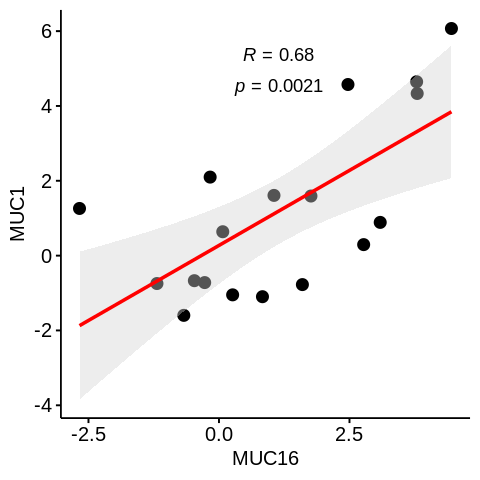

In [578]:
options(repr.plot.width = 4, repr.plot.height=4)

mt =as.data.frame(mt)
ggscatter(mt, x = "MUC16", y = "MUC1",
   color = "black",  size = 3, # Points color, shape and size
   add = "reg.line",  # Add regressin line
   add.params = list(color = "Red", fill = "lightgray"), # Customize reg. line
   conf.int = TRUE, # Add confidence interval
   cor.coef = TRUE, # Add correlation coefficient. see ?stat_cor
   cor.coeff.args = list(method = "pearson", label.x = 0.3, label.sep = "\n")
   )

In [586]:
idx = which(as.numeric(mt[,2]) < median(as.numeric(mt[,2]), na.rm = T))

In [587]:
## Statifying cell lines based on MUC1 expression

mt$Group = 0
mt$Group[idx] = "Low MUC1-exp"
mt$Group[-idx] = "High MUC1-exp"

In [588]:
head(mt)
dim(na.omit(mt))

,MUC16,MUC1,Group
,<dbl>,<dbl>,<chr>
PATU8988T_PANCREAS_TenPx03,-0.4715411,-0.6696445,Low MUC1-exp
TCCPAN2_PANCREAS_TenPx09,-0.6737940,-1.5966400,Low MUC1-exp
MIAPACA2_PANCREAS_TenPx10,-1.1881941,-0.7459547,Low MUC1-exp
QGP1_PANCREAS_TenPx11,-2.6718098,1.2604501,High MUC1-exp
SU8686_PANCREAS_TenPx12,NA,-1.5491022,Low MUC1-exp
CFPAC1_PANCREAS_TenPx13,1.7617809,1.5925822,High MUC1-exp


[1] 18  3

In [597]:
### Boxplots of MUC16 expression between MUC1 high and MUC1 low expressing cell lines using ggpubr

p = ggboxplot(mt,x="Group",y="MUC16",add=c("median_range", "jitter"), color = "Group", 
          notch = F, palette = c("Black", "Red"), size =0.7, ylab = "protein expression of MUC16")

p = p + stat_compare_means( label = "p.format", method = "t.test")
p = p +stat_n_text()

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 2 rows containing non-finite values (stat_compare_means).”
Warning message:
“Removed 2 rows containing non-finite values (stat_n_text).”
Warning message in (function (kind = NULL, normal.kind = NULL, sample.kind = NULL) :
“non-uniform 'Rounding' sampler used”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


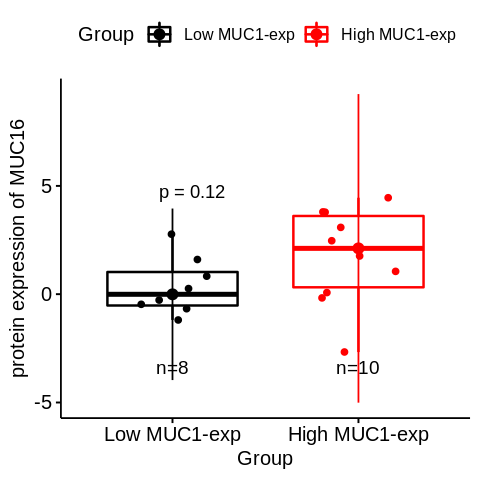

In [600]:
p